Generating a PFDHA model for the Ridgecrest, Landers, Hector Mine, and El Mayor Cucapah events based on displacement and fracture data from each event. The model uses the equation below, based on the displacement intensity and fracture density decays for each event (see the two MCMC scripts)

\begin{equation}
   P(S>S_{0}|x,M_{w}) =  e^{\frac{-S_{0}}{\beta}(\frac{x+x_d}{x_d})^{-n}} \nu_{o} (\frac{x+x_f}{x_f})^{-\gamma}
   \end{equation}

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from random import sample

# load general model data
best_fit_parameters_general_density = np.loadtxt('general_best_fit_parameters.txt', delimiter=' ')
general_g = best_fit_parameters_general_density[2]
general_xfr = best_fit_parameters_general_density[1]
general_vo = best_fit_parameters_general_density[0]


In [32]:
Ridgecrest1_displacement_parameters = np.loadtxt('Ridgecrest1_parameters_displacement.txt', delimiter=' ')
Ridgecrest2_displacement_parameters = np.loadtxt('Ridgecrest2_parameters_displacement.txt', delimiter=' ')
Landers_displacement_parameters = np.loadtxt('Landers_parameters_displacement.txt', delimiter=' ')
HectorMine_displacement_parameters = np.loadtxt('HectorMine_parameters_displacement.txt', delimiter=' ')
EMC_displacement_parameters = np.loadtxt('EMC_parameters_displacement.txt', delimiter=' ')

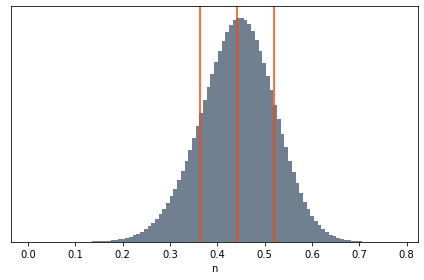

In [33]:
add_posteriors_n = np.concatenate(( Ridgecrest2_displacement_parameters[:,1] , Landers_displacement_parameters[:,1] , EMC_displacement_parameters[:,1]))
mean_n = np.mean(add_posteriors_n)
std_n = np.std(add_posteriors_n)

plt.figure()
plt.hist(add_posteriors_n,color='slategrey',bins=100)
plt.axvline(mean_n, color='orangered')
plt.axvline(mean_n-std_n, color='orangered')
plt.axvline(mean_n+std_n, color='orangered')
plt.yticks([])
plt.xlabel('n')

plt.tight_layout()
plt.savefig('n_posteriors_concat.pdf')

plt.show()

In [34]:
mean_n
std_n

0.07822783566351273

In [35]:
def PFDHAmodel(So,Mw,n,vo,x_fr,g,cinfo,alpha,labeli,a,bi,ax):
    b = np.exp((Mw-a)/bi) # from Clayton et al (2019)
    x = np.logspace(1,np.log10(10000),1000)
    PDmodel = np.exp((-So/b)*(x+1)**n)
    lambdamodel = vo * ((x+x_fr)/x_fr)**-g 
    PS_So= lambdamodel*PDmodel
    if ax==999:
        plt.plot(x,PS_So,c=cinfo,alpha=alpha,label=labeli)
    else:
        AX[ax].plot(x,PS_So,c=cinfo,alpha=alpha,label=labeli)
    return PS_So

In [36]:
# Estimating model uncertainties
def model_uncertainties(Markov_chain_density,n,sigma_n,n_draws,a,b,sigma_a,sigma_b):
    np.random.seed(0) # for reproducibility
    Markov_chain_density = np.resize(Markov_chain_density,(len(Markov_chain_density),3))


    Markov_chain_density[np.random.choice(Markov_chain_density.shape[0], 2, replace=False), :]

    vo_ensemble = Markov_chain_density[:,0] 
    d_ensemble = Markov_chain_density[:,1]
    gamma_ensemble = Markov_chain_density[:,2]
    

# randomly draw n_draws samples from a normal distribution of mean n and standard deviation sigma
    n_distribution = np.random.normal(n, sigma_n, n_draws)
    a_distribution = np.random.normal(a, sigma_a, n_draws)
    b_distribution = np.random.normal(b, sigma_b, n_draws)

    # uncertainty distributions
    fig, AX = plt.subplots(3,2,dpi=100,figsize=(3.5,5))

    hist_spec={
        "facecolor":"slategrey",
        "bins":25,
        "alpha":0.5,
    }

    AX[0,0].hist(n_distribution,**hist_spec)
    AX[0,0].set_xlabel('n')
    AX[0,1].hist(vo_ensemble,**hist_spec)
    AX[0,0].set_yticks([])
    AX[0,1].set_xlabel('$v_{o}$')
    AX[0,1].set_yticks([])
    AX[0,1].set_xlim(0,0.7)
    AX[1,1].hist(d_ensemble,**hist_spec)
    AX[1,1].set_xlabel('$x_{fr}$')
    AX[1,1].set_yticks([])
    AX[1,1].set_xlim(0,30)
    AX[1,0].hist(gamma_ensemble,**hist_spec)
    AX[1,0].set_xlabel('$\gamma$')
    AX[1,0].set_yticks([])
    AX[2,0].hist(a_distribution,**hist_spec)
    AX[2,0].set_xlabel('$a$')
    AX[2,0].set_yticks([])   
    AX[2,1].hist(b_distribution,**hist_spec)
    AX[2,1].set_xlabel('$b$')
    AX[2,1].set_yticks([]) 
    
    plt.tight_layout()
    plt.savefig('parameter_distribution_generalmodel.pdf')
    plt.show()
    
    
    return vo_ensemble, d_ensemble, gamma_ensemble, n_distribution, a_distribution, b_distribution

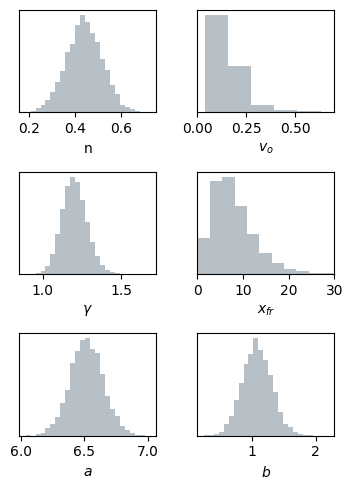

In [37]:
# Estimating model uncertainties

# load Markov chain outputs from MCMC fit to density decay to fracture population 
# (each set of three columns represents the values of vo, d, and gamma for one 
# walker in the ensemble, for a total of 200 walkers)

Markov_chain_density = pd.read_csv('general_parameters.txt',sep=' ',header=None).values


sigma_a = 0.131
sigma_b = 0.2323
a = 6.5197 # strike-slip earthquakes, from Clayton et al. (2019)
b = 1.0824 # strike-slip earthquakes, from Clayton et al. (2019)

n_draws = 5000

vo_ensemble, xfr_ensemble, gamma_ensemble, n_distribution, a_distribution, b_distribution = model_uncertainties(Markov_chain_density,mean_n,std_n,n_draws,a,b,sigma_a,sigma_b)


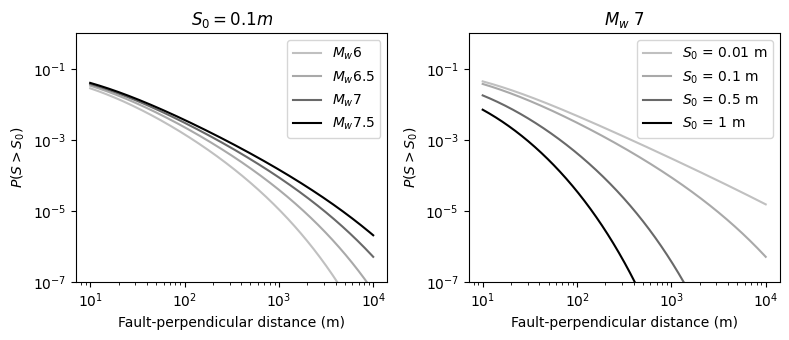

In [38]:
So = 0.1
Mw = [6,6.5,7,7.5]

fig, AX = plt.subplots(1,2,dpi=100,figsize=(8,3.5))

labels = ['$M_{w} 6$','$M_{w} 6.5$','$M_{w} 7$','$M_{w} 7.5$']
color = ['silver','darkgrey','dimgray','black']

for i in range(len(Mw)):
    P_S_So_bestfit = PFDHAmodel(So,Mw[i],mean_n,general_vo,general_xfr,general_g,color[i],1,labels[i],a,b,0)
    
    AX[0].set_xscale('log')
    AX[0].set_yscale('log')
    AX[0].set_ylabel('$P(S>S_{0}$)')
    AX[0].set_title('$S_0 = %s m$' %So)
    AX[0].set_xlabel('Fault-perpendicular distance (m)')
    AX[0].set_ylim(10**-7,1)


# Put a legend to the right of the current axis
AX[0].legend()

So = [0.01, 0.1, 0.5, 1]
Mw = 7

labels = ['$S_{0}$ = 0.01 m','$S_{0}$ = 0.1 m','$S_{0}$ = 0.5 m','$S_{0}$ = 1 m']
color = ['silver','darkgrey','dimgray','black']

for i in range(len(So)):
    P_S_So_bestfit = PFDHAmodel(So[i],Mw,mean_n,general_vo,general_xfr,general_g,color[i],1,labels[i],a,b,1)
    
    AX[1].set_xscale('log')
    AX[1].set_yscale('log')
    AX[1].set_ylabel('$P(S>S_{0}$)')
    AX[1].set_title('$M_w$ 7')
    AX[1].set_xlabel('Fault-perpendicular distance (m)')
    AX[1].set_ylim(10**-7,1)


# Put a legend to the right of the current axis
AX[1].legend()

plt.tight_layout()
plt.savefig('PFDHAmodel_general_3S0_Mw7.pdf')
plt.show()


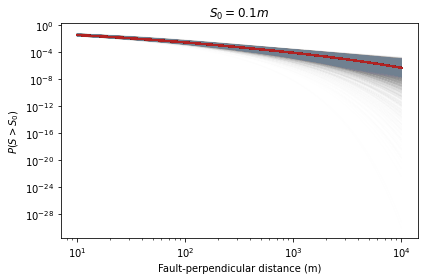

In [62]:
# for an individual model of a single magnitude

So = 0.1
Mw = 7
P_S_So_bestfit = PFDHAmodel(So,Mw,mean_n,general_vo,general_xfr,general_g,'slategrey',1,'$M_w$ 7',a,b,1)
# arrays for calculating confidence intervals 
PS_So = []
residuals = []

plt.figure()

for i in range(5000):
    i_PS_So = PFDHAmodel(So,Mw,n_distribution[i],vo_ensemble[i],xfr_ensemble[i],gamma_ensemble[i],'slategrey',0.002,'',a_distribution[i],b_distribution[i],999)
    PS_So.append(i_PS_So)
    residuals.append(np.log(i_PS_So) - np.log(P_S_So_bestfit))
    PFDHAmodel(So,Mw,mean_n,general_vo,general_xfr,general_g,'firebrick',1,'',a,b,999)

plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P(S>S_{0}$)')

plt.title('$S_0 = %s m$' %So)
plt.xlabel('Fault-perpendicular distance (m)')
#plt.ylim(10**-7,1)

PS_So = np.array(PS_So)
residuals = np.array(residuals)
assert PS_So.shape == residuals.shape

sigma_16_PS_So = np.percentile(PS_So,16,axis=0) # 16
sigma_84_PS_So = np.percentile(PS_So,84,axis=0) # 84
sigma_16_res = np.percentile(residuals,16,axis=0)
sigma_84_res = np.percentile(residuals,84,axis=0)


# Put a legend to the right of the current axis
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('PFDHAmodel_general.pdf')
plt.show()

In [67]:
arr1 = np.array([[1,2,3,4],[3,4,6,7]])
np.percentile(arr1,84,)

5.76

In [63]:
def expc(x, a):
    return a*np.exp(x**0.15)


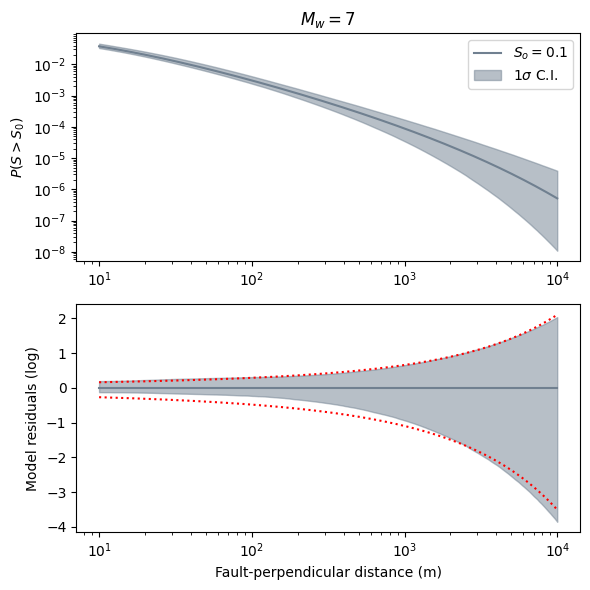

In [64]:

fig, AX = plt.subplots(2,1,dpi=100,figsize=(6,6)) # ,sharex=True

line_spec = {
    "alpha":0.5,
    "color":"slategrey",
    "label":"1$\sigma$ C.I."
}

x = np.logspace(1,np.log10(10000),1000)

AX[0].fill_between(x,sigma_16_PS_So,sigma_84_PS_So, **line_spec)

AX[1].fill_between(x,sigma_16_res, sigma_84_res, **line_spec)
popt84, pcov84 = curve_fit(expc, x, sigma_84_res)
popt16, pcov16 = curve_fit(expc, x, sigma_16_res)
AX[1].plot(x, expc(x, *popt84), c='r',linestyle=':')
AX[1].plot(x, expc(x, *popt16), c='r',linestyle=':')

AX[0].set_yscale('log')
AX[0].set_xscale('log')
AX[0].set_ylabel('$P(S>S_{0})$')

AX[0].plot(x,P_S_So_bestfit,c='slategrey',label='$S_{o} = %.1f$' %(So))
AX[0].legend()
AX[0].set_title('$M_w = %s$' %Mw)
AX[1].plot(x,np.log(P_S_So_bestfit)-np.log(P_S_So_bestfit), color='slategrey')
AX[1].set_xscale('log')
AX[1].set_xlabel('Fault-perpendicular distance (m)')
AX[1].set_ylabel('Model residuals (log)')

plt.tight_layout()

plt.savefig('General_model_uncert.pdf')
plt.show()

In [65]:
popt16

array([-0.06547742])

In [44]:
popt84

array([0.01706496])